# LAB1: processing ECG signals <a target="_blank" href="https://colab.research.google.com/github/zamaS24/DCP_Labs/blob/master/DCP_lab1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **:warning: if you are opening this and executing it in colab, you should set the variable below to `True`**

In [1]:
colab = False

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

# 1. Ecg signal acquisition
we'll be using the [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/)

In [3]:
# downlaoding the database
if colab: 
    !wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

In [4]:
# Investigating the structure
import os

dir = 'physionet.org/files/mitdb/1.0.0/' if colab else "mit-bih-arrhythmia-database-1.0.0"

for root, folders, files in os.walk(dir):
    for folder in folders:
        print(os.path.join(root, folder))

mit-bih-arrhythmia-database-1.0.0\mitdbdir
mit-bih-arrhythmia-database-1.0.0\x_mitdb
mit-bih-arrhythmia-database-1.0.0\mitdbdir\samples
mit-bih-arrhythmia-database-1.0.0\mitdbdir\src


> **💡INFO**  
> * It seems that the directory contains a lot of data files in different formats, ans we can even find some C source codes on how they generated the files in the mitdbdir\src\
> * In the dataset description they said that they have 48 records of half hour duration of ECG signals. So it must be the files under the mitdbdir\ folder

### Investigating only the .dat files, since they are files that holds the actual data we need for processing

In [5]:
file_paths = []

paths = os.listdir(dir)
for path in paths:
    if path.endswith(".dat"):
        print(path)
        file_paths.append(path)

print('number of total records are : ', len(file_paths))

100.dat
101.dat
102.dat
103.dat
104.dat
105.dat
106.dat
107.dat
108.dat
109.dat
111.dat
112.dat
113.dat
114.dat
115.dat
116.dat
117.dat
118.dat
119.dat
121.dat
122.dat
123.dat
124.dat
200.dat
201.dat
202.dat
203.dat
205.dat
207.dat
208.dat
209.dat
210.dat
212.dat
213.dat
214.dat
215.dat
217.dat
219.dat
220.dat
221.dat
222.dat
223.dat
228.dat
230.dat
231.dat
232.dat
233.dat
234.dat
number of total records are :  48


####  some notes about .dat file extension
in the database we have multiple ecg records
each record has some files : .atr .dat .hea .xws
and in the .dat file we have three attributes :
* psignal : 2d np array
* fs: sampling frequency
* sginame: the name of the actual 2 signals presented in the psignal attribute

## reading the .dat file


In [6]:
if colab: 
    !pip install wfdb

In [7]:
## Reading the .dat file and return a nparray of its values

import wfdb
print('version of the library ', wfdb.__version__)

# read the record 100

record = wfdb.rdrecord(os.path.join(dir, '100'))


signal = record.p_signal
fs = record.fs
sig_name = record.sig_name

print('*** some characteristics *** ')
print('signal:', signal)
print('Shape of the np arary:', signal.shape)
print('fs:', fs)
print('sig_name', sig_name)
print('***')

version of the library  4.1.2
*** some characteristics *** 
signal: [[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]
Shape of the np arary: (650000, 2)
fs: 360
sig_name ['MLII', 'V5']
***


###  display the both signals record with integrated library plotting function

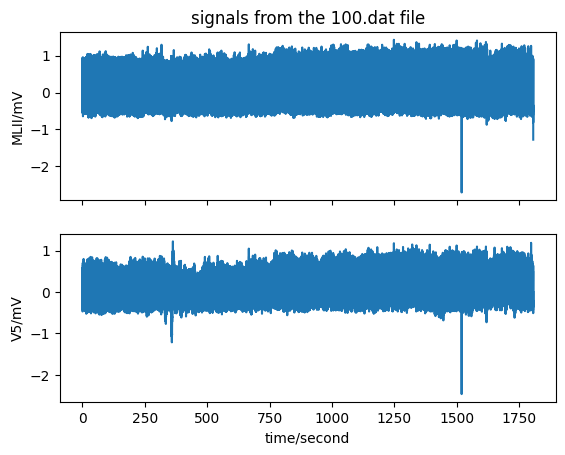

In [8]:
wfdb.plot_wfdb(record=record, title='signals from the 100.dat file')

### displaying the signal (only a small part of it to have a clear idea of it)

In [9]:
# plotting the first signal only using plotly and we will delimit it only to the first 1440 samples  becasue the whole signal will not make us see the waves correctly

def display_portion_signal(begin:int, end:int, dimension:int) -> None: 
    """Function that takes slice of the signal and plots it """

    
    plt.figure(figsize = (20,4), dpi = 100)
    plt.plot(signal[begin:end, dimension], label=f'Channel {dimension}')
   

    plt.title(f'Ecg Signal of the  dimension number {dimension}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.legend()
    plt.show()


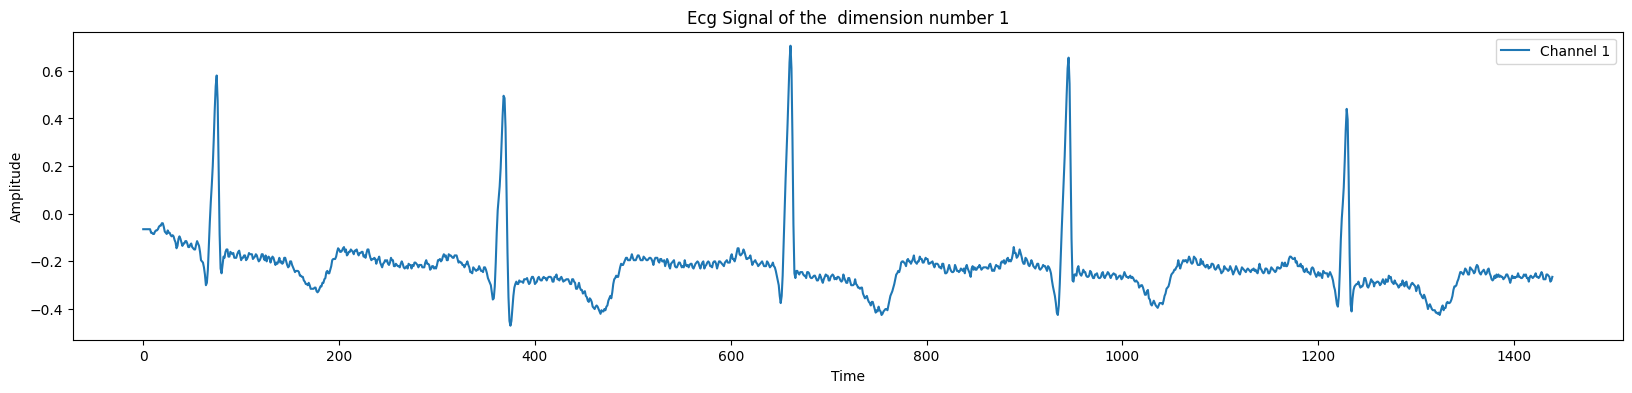

In [10]:
display_portion_signal(0,1440, 1)

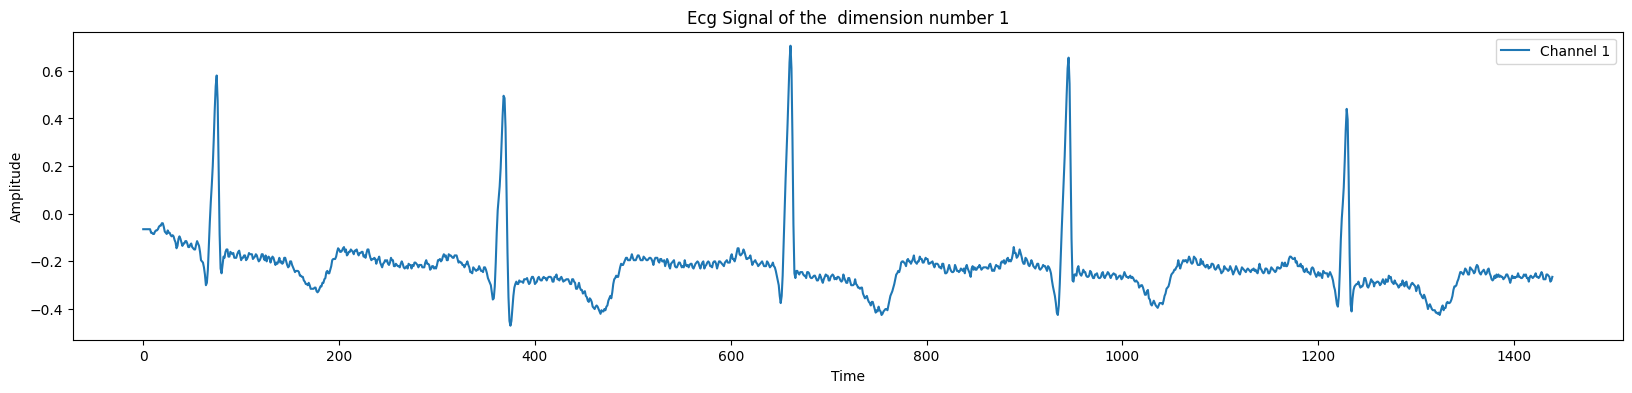

In [11]:
display_portion_signal(0,1440, 1)

# 2. Basig signal characteristics

## 2.1 Average signal value (mean of the signal)


In [12]:
mean = np.mean(signal[:,0])
mean

-0.3062989769230769

## 2.2 Energy of the signal (sum of the squared values)


In [13]:
energy = np.sum(np.square(signal[:,0]))
energy

85244.33212499997

## 2.3 Variance


In [14]:
var = np.var(signal[:,0])
var

0.037326063082030236

## 2.4 Signal to noise ration

In [15]:

snr = signal[:,0].mean()/signal[:,0].std()
snr

-1.5854021885079466

# 3. R peak detection

## 3.1 thresholding technique
based on this :link:[paper](https://www.irjet.net/archives/V6/i4/IRJET-V6I4479.pdf)  
    -> first we would mark, a certain threshold, let's say 0 for instance, it will give us some great values 

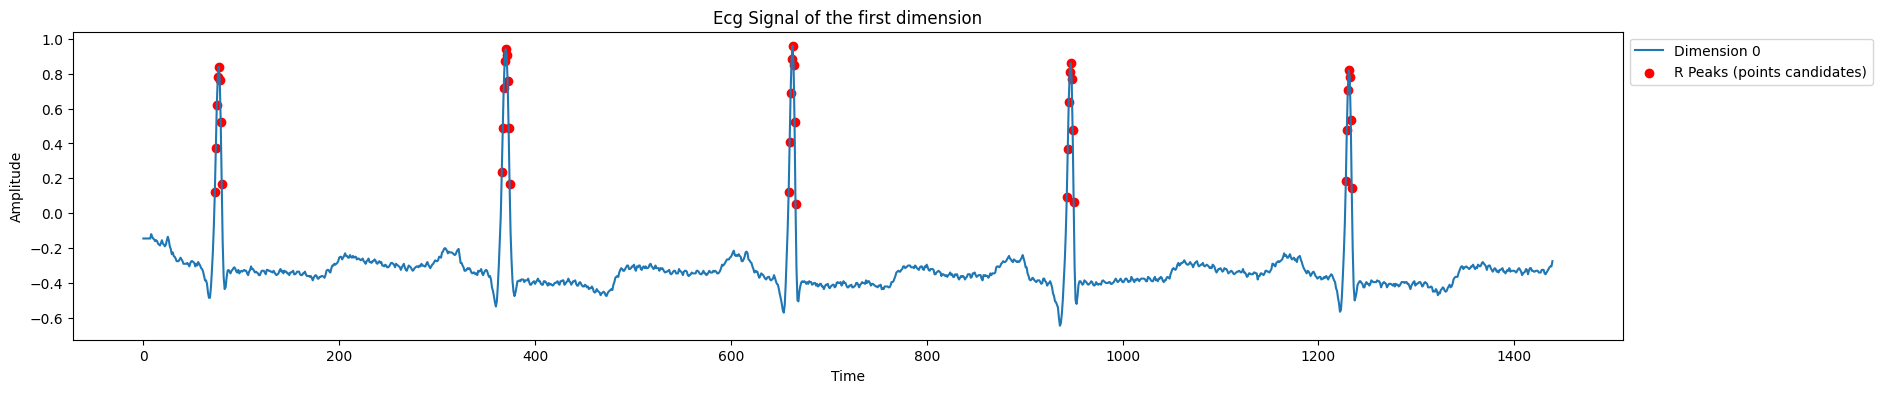

In [16]:
threshold = 0


r_peak_indices = np.where(signal[0:1440,0] > threshold) # be careful, return type is a tupe, hence to acces it is r_peak_idices[0]

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(
    signal[0:1440, 0],
    label=f'Dimension {0}'
)



plt.scatter(
    r_peak_indices[0],
    signal[r_peak_indices[0], 0],
    color='red',
    label='R Peaks (points candidates)'
)
plt.title('Ecg Signal of the first dimension')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

the real peaks, are those who satisfies the condition : it's the greater in his neighberhood.  
meaning greater than both the previous and the next value. (maximum local)

In [17]:

real_peak_indices = [idx for idx in r_peak_indices[0] 
    if signal[0:1440,0][idx] > max(signal[0:1440,0][idx-1],signal[0:1440,0][idx+1])]

real_peak_indices = np.array(real_peak_indices)
real_peak_indices

array([  77,  370,  663,  947, 1231], dtype=int64)

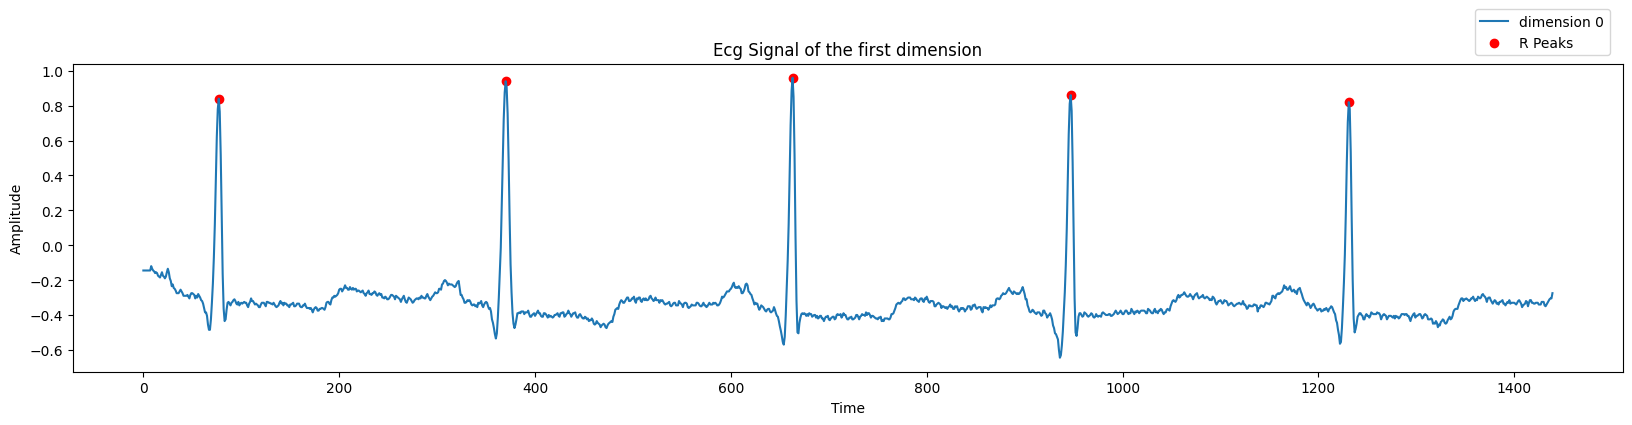

In [18]:

# Plotting the results 
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(
    signal[0:1440, 0],
    label=f'dimension {0}'
)


plt.scatter(
    real_peak_indices,
    signal[real_peak_indices, 0],
    color='red',
    label='R Peaks'
)

plt.title('Ecg Signal of the first dimension')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1.2))
plt.show()

## 3.2 Pan tompkins algorithm
- based on :link:[this article](https://medium.com/@clauciorank/electrocardiogram-qrs-detection-using-pan-tompkins-algorithm-and-r-programming-language-c65c916e6ab5)    
- Algortihm is following these steps:     
![process](./assets/pan_tompking_algo.webp)

### 3.2.1 Low high pass filter 

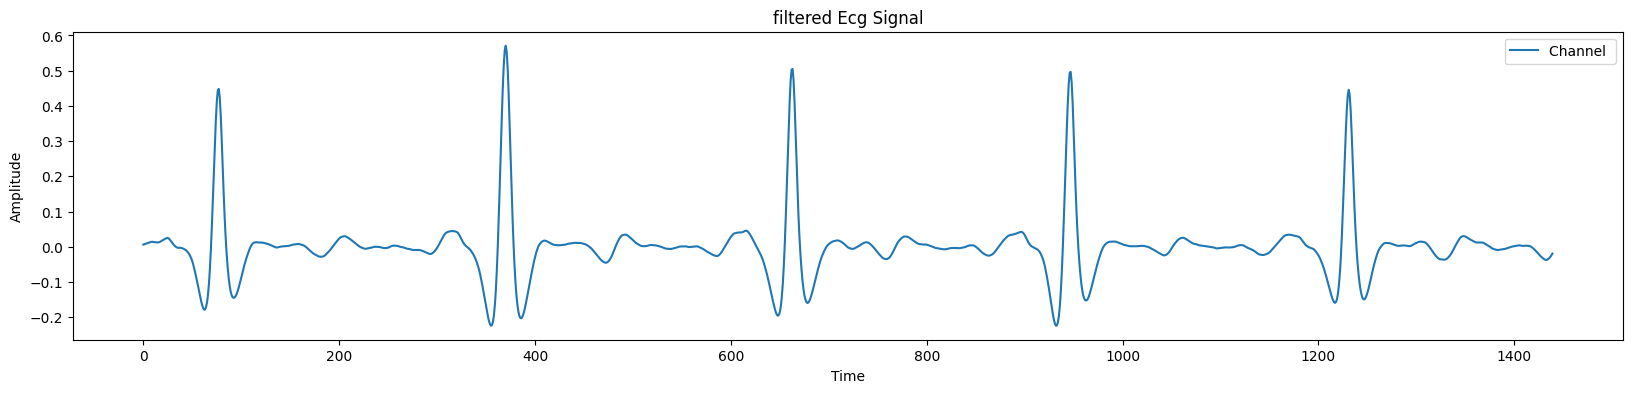

In [19]:
from scipy.signal import butter, filtfilt, find_peaks

# <max_freq low pass
# >min_freq high pass

# min_freq < filteredsignal < max_freq , combining low and high

# Bandpass filter
def bandpass_filter(signal, fs, lowcut, highcut):
    """low/hihgh pass filter 
    @param lowcut: min frequency
    @param highcut: max frequency"""

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    return filtfilt(b, a, signal)


filtered_signal = bandpass_filter(signal[0:1440,0], fs, 5, 15)

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(filtered_signal, label=f'Channel ')

plt.title(f'filtered Ecg Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### 3.2.2 derivatie filter

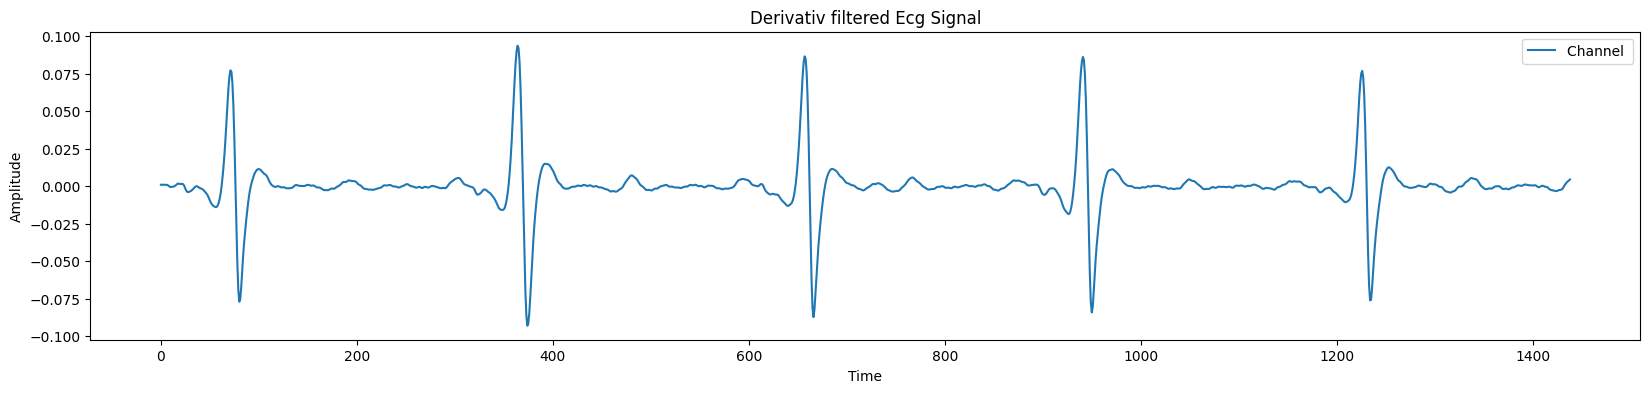

In [38]:
# DOCS: np.diff numpy.diff(a, n=1, axis=-1, prepend=<no value>, append=<no value>)[source] Calculate the n-th discrete difference along the given axis.
# https://numpy.org/doc/stable/reference/generated/numpy.diff.html


diff_signal = np.diff(filtered_signal)
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(diff_signal, label=f'Channel ')

plt.title(f'Derivativ filtered Ecg Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### 3.2.3 squaring

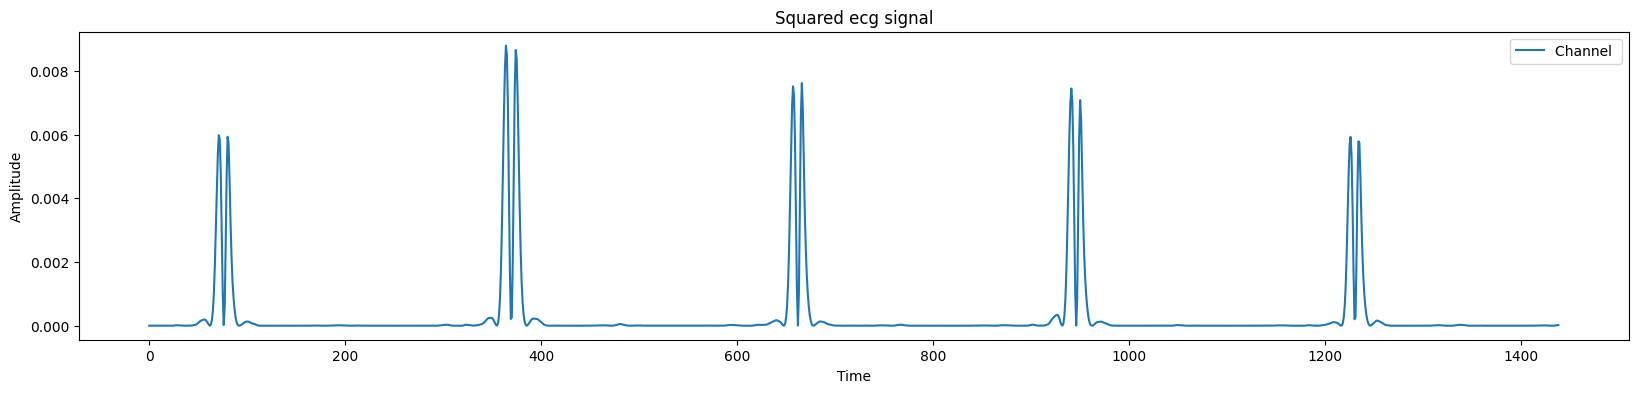

In [21]:
squared_signal = diff_signal ** 2
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(squared_signal, label=f'Channel ')

plt.title(f'Squared ecg signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### 3.2.3 Moving average

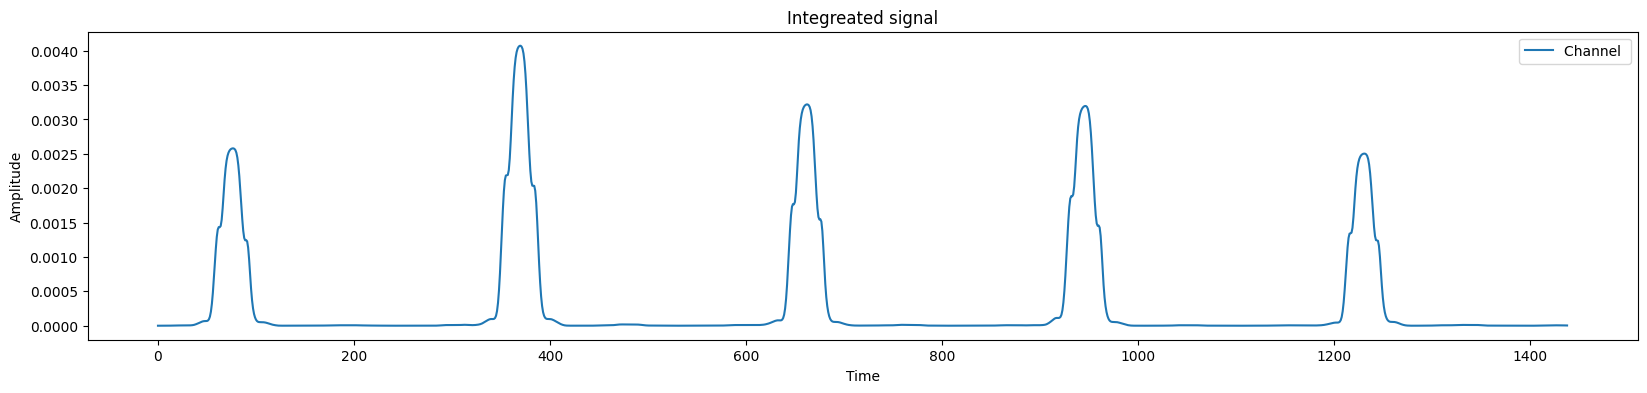

In [22]:
window_size = int(0.075 * fs)  # 150 ms window


integrated_signal = np.convolve(squared_signal, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(integrated_signal, label=f'Channel ')

plt.title(f'Integreated signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### 3.2.3 peak detection

In [23]:
threshold_value = np.max(integrated_signal) * 0.5  # Example threshold, adjust as needed
print('threshold value = ', threshold_value)
peaks, _ = find_peaks(integrated_signal, height=threshold_value)

peaks

threshold value =  0.0020365883856699467


array([  77,  370,  662,  946, 1231], dtype=int64)

In [24]:
integrated_signal[peaks]

array([0.00257961, 0.00407318, 0.00321931, 0.00319626, 0.0025039 ])

In [25]:
integrated_signal[663]*10000

32.18769116122149

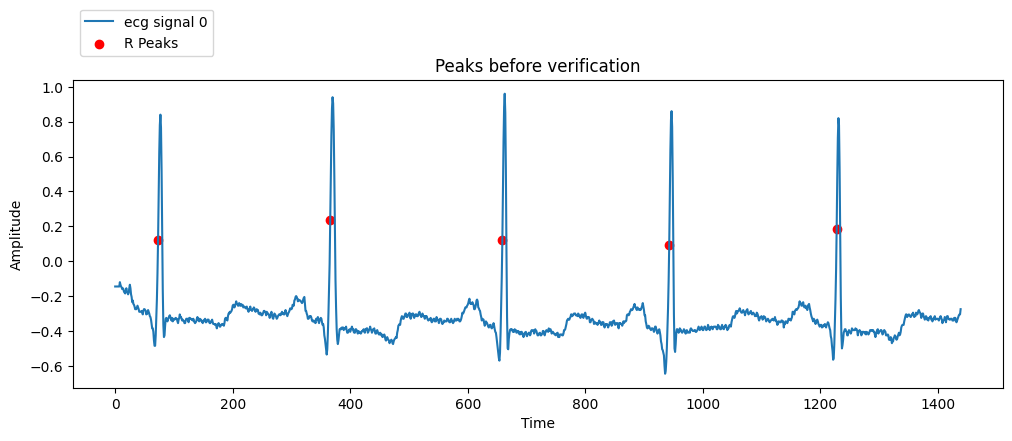

In [39]:
# Plotting the results 
plt.figure(figsize = (12,4), dpi = 100)
plt.plot(
    signal[0:1440, 0],
    label=f'ecg signal {0}'
)


plt.scatter(
    peaks,
    signal[0:1440,0][peaks],
    color='red',
    label='R Peaks'
)


plt.title('Peaks before verification')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.25))
plt.show()


it appears that this method, doesn't really capture the exact peaks, when we see the plot, it actually finds 3 out of 5.
improving this, would have to verify the peaks in the original signal, and not taking directly the indices from the integrated signal.

 we need to verify if the peaks are truly the peaks, if not change them by checking if a neighberhood is a peak 

In [27]:
r_peaks = []
for idx in peaks: 
    if signal[0:1440,0][idx] > max(signal[0:1440,0][idx+1],signal[0:1440,0][idx-1]):
        r_peaks.append(idx)

    else: 
        if signal[0:1440,0][idx] < signal[0:1440,0][idx-1] and signal[0:1440,0][idx] > signal[0:1440,0][idx+1]:
            r_peak_indices.append(idx-1)

        if signal[0:1440,0][idx] < signal[0:1440,0][idx+1] and signal[0:1440,0][idx] > signal[0:1440,0][idx-1]:
            r_peaks.append(idx+1)

         
r_peaks


[77, 370, 663, 947, 1231]

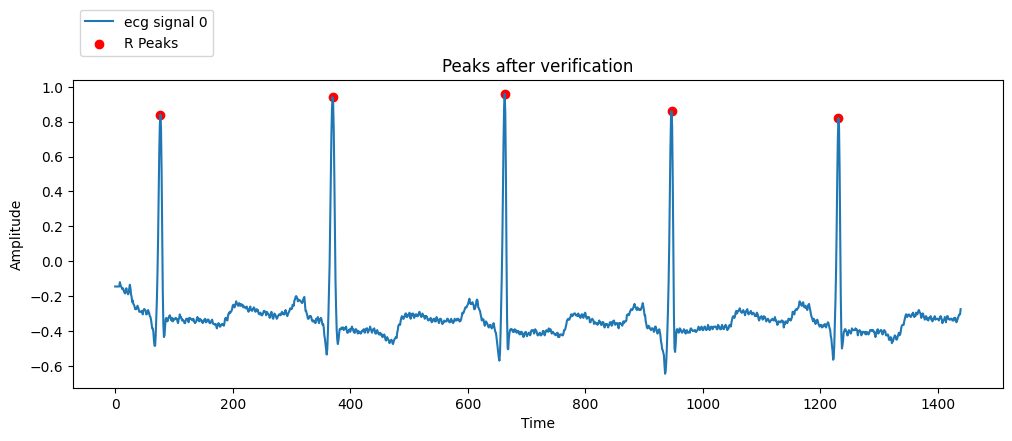

In [40]:
# Plotting the results if another check 
plt.figure(figsize = (12,4), dpi = 100)
plt.plot(
    signal[0:1440, 0],
    label=f'ecg signal {0}'
)


plt.scatter(
    r_peaks,
    signal[0:1440,0][r_peaks],
    color='red',
    label='R Peaks'
)


plt.title('Peaks after verification')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.25))
plt.show()


## 3.3 Derivative based approache

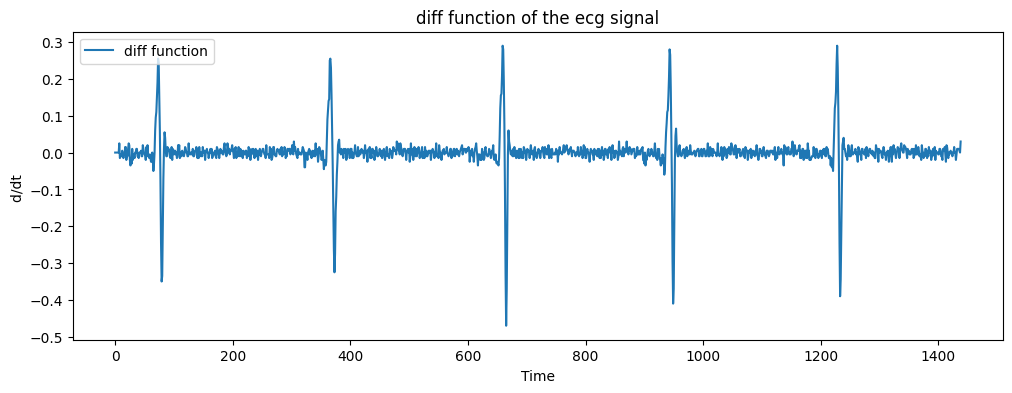

In [29]:
diff = np.diff(signal[:1440,0]) # diff[i] = signal[i+1] - signal[i]
mean_diff = np.mean(diff)


# ploting teh derivative 
# Plotting the results if another check 
plt.figure(figsize = (12,4), dpi = 100)
plt.plot(
    diff,
    label=f'diff function'
)



plt.title('diff function of the ecg signal')
plt.xlabel('Time')
plt.ylabel('d/dt ')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
plt.show()

In [30]:
# correct values should be : [77, 370, 663, 947, 1231]
peaks = find_peaks(diff, height=0.2)[0]


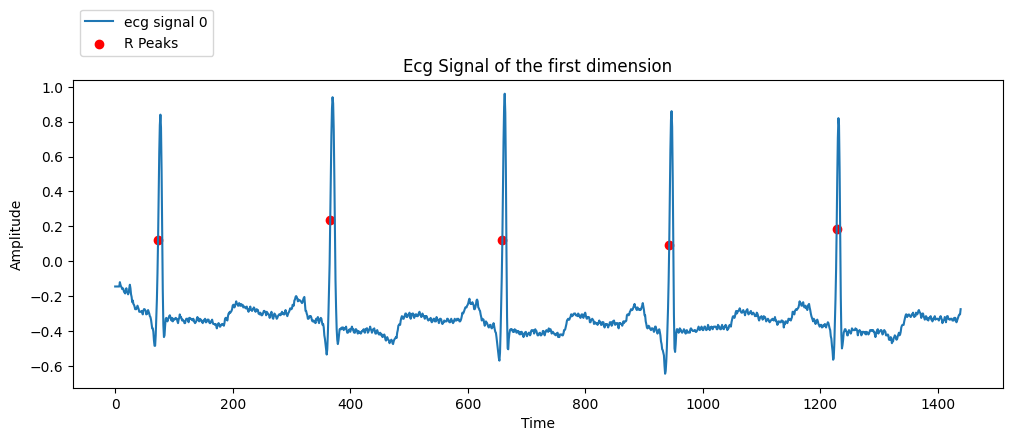

In [31]:
# plotting the peaks 
# Plotting the results if another check 
plt.figure(figsize = (12,4), dpi = 100)
plt.plot(
    signal[0:1440,0],
    label=f'ecg signal {0}'
)


plt.scatter(
    peaks,
    signal[0:1440,0][peaks],
    color='red',
    label='R Peaks'
)


plt.title('Ecg Signal of the first dimension')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.25))
plt.show()

> **:warning: It appears that this method isn't good enough, since it's close to the peaks but not the actual peaks**

# 4. Cardiovascular Parameter Calculation

### 4.1 heart rate per minute (BPM)

In [32]:
# number of r beats in one minute
print('sampling requency : ', fs)
print(f'we have {fs} in one second, and {fs*60} in one minute')
print(f'shape of the signal : ', signal.shape)

threshold = 0


r_peak_indices = np.where(signal[0:21600,0] > threshold)
real_peak_indices = [idx for idx in r_peak_indices[0] 
    if signal[0:21600,0][idx] > max(signal[0:21600,0][idx-1],signal[0:21600,0][idx+1])]

real_peak_indices = np.array(real_peak_indices)
bpm = len(real_peak_indices)


print(f'BPM = {bpm}')

sampling requency :  360
we have 360 in one second, and 21600 in one minute
shape of the signal :  (650000, 2)
BPM = 73


### 4.2 RR intervals 
I will take the average value of rr intervals in a one minute signal

In [33]:
rr = np.diff(np.array(real_peak_indices)).mean() *1/360
print(f'average time between two consecutive R peaks in one minute is : {rr} seconds')

average time between two consecutive R peaks in one minute is : 0.8235725308641975 seconds


### 4.3 Heart rate variablility (HRV)

In [34]:
std = np.diff(np.array(real_peak_indices)).std()
std

36.35205674127652

### **:memo: Summary**   

| metric | value |
|:--|:--|
|BPM|73 |
|Average time of RR intervals| 0.8235725308641975 s| 
| HRV | 36.35205674127652| 

based on wikipedia the BPM of 73 means the patient is healthy for an adult, since it's between 60 - 100.